# E5 Spectrogram classification

## !! 프로젝트 목표 : 2D 스펙토그램을 이용하여 Classification 모델 구현

## 1. 데이터 처리와 분류

### 1) 라벨 데이터 처리하기 
### 2) sklearn의 train_test_split함수를 이용하여 train, test 분리

#### ! 일단 데이터 가져 와서 분석

In [10]:
import numpy as np
import os
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
import librosa
import librosa.display
import matplotlib.pyplot as plt


data_path = os.getenv("HOME")+'/Spectrogram_classification/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [11]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [12]:
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  398
Wave data shape :  (8000,)
label :  ['down']


In [13]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


#### ! 데이터 가져오니 50,620개 데이터의 라벨을 매기고 unkwon과 silence를 추가함

#### ! 이제는 텍스트를 index 작업

In [14]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data
#label_data.shape

array([ 3,  3,  3, ..., 11, 11, 11])

### 학습을 위해 데이터 분리

In [16]:
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

print(train_label)
print(test_label)

#train_spect = train_spect.reshape([-1, sr, 1]) # add channel for CNN
#test_spect = test_spect.reshape([-1, sr, 1]) # 계속 에러 난다.. 왜이러지.....

print(" ")
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

[5 4 5 ... 1 4 6]
[ 6  4 11 ...  3  3  1]
 
train data :  (45558, 8000)
train labels :  (45558,)
test data :  (5062, 8000)
test labels :  (5062,)


### 여기까지는 데이터 불러와서 학습/ 테스트 데이터로 분리

## 2. 학습을 위한 하이퍼파라미터 설정

In [17]:
batch_size = 16  # 본래 32개 속도를 고려하여 사이즈와 에폭 수정하고 있음.
max_epochs = 10   # 본래 10개

checkpoint_dir = os.getenv('HOME')+'/Spectrogram_classification/models/wav'

checkpoint_dir

'/home/aiffel-dj29/Spectrogram_classification/models/wav'

### 나중에 학습 속도를 보고 batch size와 epochs를 바꿀꺼임

## 3. 데이터셋 구성

### 데이터셋 구성 전에 1D wav 데이터를 2D Spectrogram 데이터로 전환

In [18]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

### 먼저 train 데이터를 2D spectrogram으로 변환

In [19]:
train_spect = []

for wav in train_wav:
    train_spect.append(wav2spec(wav))
    
train_spect = np.array(train_spect)

train_wav.shape

(45558, 8000)

In [20]:
train_spect.shape

(45558, 130, 126)

### 이제는 test 데이터도 2D 변환

In [21]:
test_spect = []

for wav in test_wav:
    test_spect.append(wav2spec(wav))
    
test_spect = np.array(test_spect)

test_wav.shape

(5062, 8000)

In [22]:
test_spect.shape

(5062, 130, 126)

### 스펙트로 그램 그려 보자

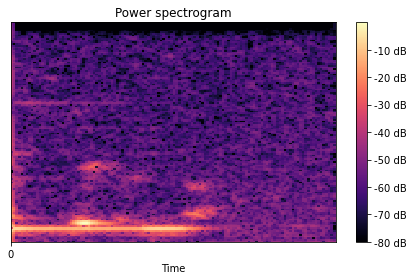

In [23]:
librosa.display.specshow(librosa.amplitude_to_db(train_spect[100], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()


    a. tf.data.Dataset을 이용
    b. from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
    c. map과 batch를 이용한 데이터 전처리
    주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
    d. tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.


In [25]:
sr = train_spect.shape[1]
sc = train_spect.shape[2]

train_spect = train_spect.reshape([-1, sr, sc, 1]) # add channel for CNN  아 정말 오래 찾았다...
test_spect = test_spect.reshape([-1, sr, sc, 1]) # 계속 에러 난다.. 왜이러지.....

print(train_spect.shape)
print(test_spect.shape)

(45558, 130, 126, 1)
(5062, 130, 126, 1)


### 하테하테 라벨이..

In [26]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

### 대망의 데이터 셋 만들기

In [27]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spect, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print("Train dataset : ", train_dataset)
print(" ")

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spect, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print("Test dataset : ",test_dataset)

Train dataset :  <BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
 
Test dataset :  <BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


### 제일 위에 있는 스피치 데이터 원본은 이제 다 썼으니 지워서 메모리 확보

In [29]:
del speech_data
#del spec_data
#del spec_arr

NameError: name 'speech_data' is not defined

## 학습 모델 빌드

    a. 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
    b. batchnorm, dropout, dense layer 등을 이용
    c. 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
    d. 모델 가중치를 저장하는 checkpoint callback 함수 추가
    e. 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [30]:
input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128)(x) # 속도 좀 줄이게 깊이를 줄임 본래 256
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

### Loss값 계산

In [31]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### Train

In [32]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

### 가자 !!!   이번에는 잘 돌아야 한다. 죽지마~

In [33]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spect) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spect) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
2847/2847 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.7717
Epoch 00001: val_loss improved from inf to 0.33446, saving model to /home/aiffel-dj29/Spectrogram_classification/models/wav
2847/2847 [==============================] - 287s 101ms/step - loss: 0.7052 - accuracy: 0.7717 - val_loss: 0.3345 - val_accuracy: 0.8892
Epoch 2/10
2847/2847 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9243 ETA: 3s - E
Epoch 00002: val_loss improved from 0.33446 to 0.22242, saving model to /home/aiffel-dj29/Spectrogram_classification/models/wav
2847/2847 [==============================] - 294s 103ms/step - loss: 0.2462 - accuracy: 0.9243 - val_loss: 0.2224 - val_accuracy: 0.9290
Epoch 3/10
2847/2847 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9474
Epoch 00003: val_loss improved from 0.22242 to 0.21918, saving model to /home/aiffel-dj29/Spectrogram_classification/models/wav
2847/2847 [=============================

### 오우 살았다.. 커널이 견딘거야 !!!!!  고맙다   (feat. 5번을 울고 다시 한번)

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

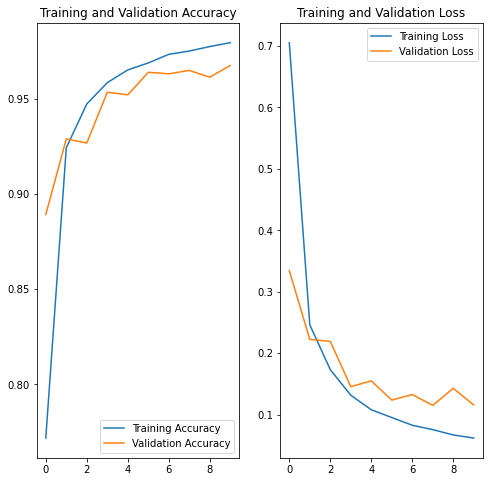

In [34]:
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 학습한 것과 평가가 비슷한 수준으로 따라 가는 것을 보니 잘 학습 된것 같은???

### Evaluation

In [35]:
model_wav.load_weights(checkpoint_dir)

### 얼마나 예측값이 실제와 가까운지 봅시다 !!

In [36]:
results = model_wav.evaluate(test_dataset)

317/317 [==============================] - 23s 72ms/step - loss: 0.1150 - accuracy: 0.9650


In [37]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.115
accuracy value: 96.5034%


96% 정확도에 로스가 0.1

## 6. Test dataset을 이용해서 모델의 성능을 평가

In [39]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spect), size=1, replace=False)

batch_xs = test_spect[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))
print("y_pred: ", str(inv_label_value[np.argmax(y_pred_)]))

#ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  down
y_pred:  down


### 오케이 맞았고.

## 7. Skip-connection model

## Skip 모델

In [42]:
input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)  # 요놈이 스킵이구만 ㅋㅋ

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 130, 126, 32) 2624        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 65, 63, 32)   0           conv2d_28[0][0]                  
____________________________________________________________________________________________

## Drop_out 덕분에 1천만개 파라메터가 줄었다... 괜찮은건가?  나중에 결론이 나오겠지

### Loss

In [43]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [44]:
checkpoint_dir = os.getenv('HOME')+'/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

### 다시 도전 !!  제발 살아 주세요.

In [45]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spect) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spect) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
2847/2847 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.7890
Epoch 00001: val_loss improved from inf to 0.28532, saving model to /home/aiffel-dj29/speech_recognition/models/wav_skip
2847/2847 [==============================] - 313s 110ms/step - loss: 0.6707 - accuracy: 0.7890 - val_loss: 0.2853 - val_accuracy: 0.9114
Epoch 2/10
2847/2847 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.9350
Epoch 00002: val_loss improved from 0.28532 to 0.16895, saving model to /home/aiffel-dj29/speech_recognition/models/wav_skip
2847/2847 [==============================] - 318s 112ms/step - loss: 0.2156 - accuracy: 0.9350 - val_loss: 0.1690 - val_accuracy: 0.9438
Epoch 3/10
2847/2847 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9543
Epoch 00003: val_loss improved from 0.16895 to 0.16697, saving model to /home/aiffel-dj29/speech_recognition/models/wav_skip
2847/2847 [==============================] - 329s 116ms/step 

### 시각화

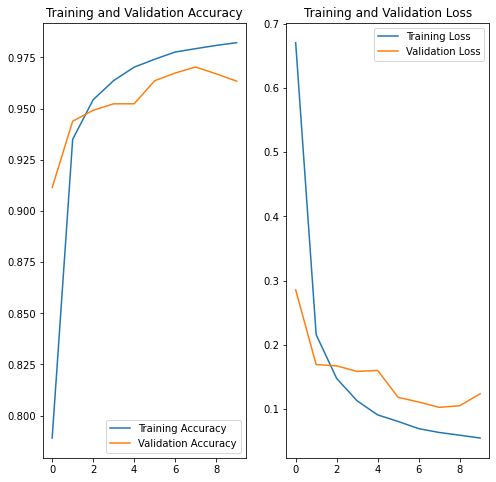

In [46]:
acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation

In [47]:
model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

317/317 [==============================] - 13s 40ms/step - loss: 0.1022 - accuracy: 0.9704
loss value: 0.102
accuracy value: 97.0367%


## Test

In [50]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spect), size=1, replace=False)

batch_xs = test_spect[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))
print("y_pred : ", str(inv_label_value[np.argmax(y_pred_)]))

label :  right
y_pred :  right


## 회고록....

#### 1. Skip connection의 유무를 비교 해 보면
####     무 : accuracy - 96.5%   loss - 0.5
####     유 : accuracy - 97.0%   loss - 0.1
####    결론 : 나의 케이스는 skip 기능이 더 좋은 기능으로 결론이 나왔다. 다른 팀원은 안 좋은 결과를 가지는데 저는 모든 모델을 다 쓰는데 집중하였다.

#### 2. 어려웠던 부분 : 1D wave 에서 2D spectrogram 만드는게 어려웠음.
####                             2차원으로 늘어나면서 각 함수의 속성값들을 맞추는데 어려웠음..  디버깅하면서 찾음
####                             모델의 파라메터가 늘어 나면서 커널이 죽는 현상을 많이 겪음.